In [1]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
!git clone https://github.com/anirudh9784/Adversarial-Attacks-and-Defences.git
!mkdir data
!mkdir extra

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-x0dn0o6y/cleverhans_abceac081c0249eeb576d860d35c9db6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/cleverhans.git /tmp/pip-install-x0dn0o6y/cleverhans_abceac081c0249eeb576d860d35c9db6
  Resolved https://github.com/tensorflow/cleverhans.git to commit 574efc1d2f5c7e102c78cf0e937654e847267522
  Preparing metadata (setup.py) ... done
fatal: destination path 'Adversarial-Attacks-and-Defences' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘extra’: File exists


In [25]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [3]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [4]:
# Pre-processing images

def load_image(path):
  img = keras.utils.load_img(path, target_size=(224,224,3)) # loading image from path
  img = keras.utils.img_to_array(img) # converting image to array
  img = img/255. # normalizing pixel values to lie between 0 & 1
  img = np.array([img]) # converting to numpy array
  return img

In [5]:
# Dataset size

data_dir = './Adversarial-Attacks-and-Defences/Dataset/'
img_names = os.listdir(data_dir)
img_names.sort()
print(f"Dataset Size: {len(img_names)}")

Dataset Size: 239


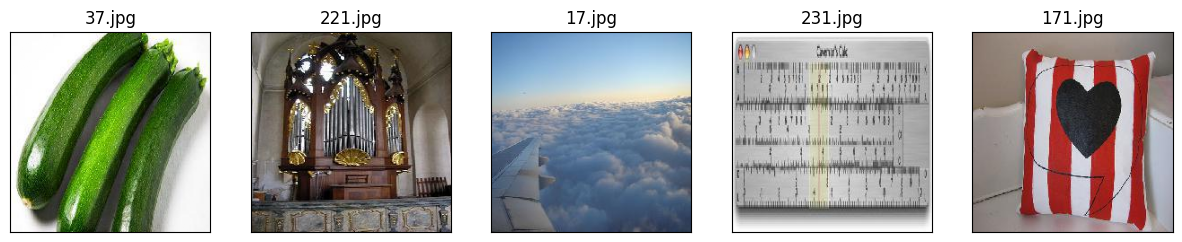

In [6]:
# Dataset preview
# ImageNet dataset is a diverse dataset consisting of 1000 different classes

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(5):
  img_path = os.path.join(data_dir, img_names[i])
  img = load_image(img_path)[0]

  ax = plt.subplot(1, 5, i+1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(img)
  plt.title(img_names[i])

In [7]:
# Loading model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

pretrained_model = MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

In [8]:
# FGSM Attack

# model_fn - pretrained model that generates 'ground truth' labels (actual ground truth isn't used to avoid label leaking)
# x - preprocessed input image converted to a tensor of size 224 x 224
# eps - input variation parameter
# norm - must be either np.inf, 1, or 2

from cleverhans.tf2.attacks import fast_gradient_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)

def fgsm_attack(image):
  epsilon = 0.1
  adv_example_untargeted_label = fast_gradient_method(
      model_fn=logits_model,
      x=image,
      eps=epsilon,
      norm=np.inf
      )
  return adv_example_untargeted_label[0]

In [9]:
# Momentum Iterative Method

from cleverhans.tf2.attacks import momentum_iterative_method
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)

def mim_attack(image):
  epsilon = 0.1
  adv_example_untargeted_label = momentum_iterative_method(
      model_fn=logits_model,
      x=image,
      eps=epsilon
      )
  return adv_example_untargeted_label[0]

In [10]:
# Loading ResNet model to test the adverarial examples on
# Checking to see if adversarial examples trained on MobileNetV2 work on Resnet50, to see if adversarial examples generalize well

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import decode_predictions

model = ResNet50(weights='imagenet')


In [11]:
# Returns resnet prediction for an image

def resnet_prediction(path):
  probs = model.predict((cv2.imread(path)[None,:,:,:]))
  _, pred, prob = decode_predictions(probs, top=1)[0][0]
  return pred, prob

In [35]:
# Gets resnet predictions on original image, fgsm adversarial example and mim adversarial example for all images

def get_predictions():
  og_preds = []
  fgsm_preds = []
  mim_preds = []

  # initialize output directories
  fgsm_imgs = './fgsm_images/'
  mim_imgs = './mim_images/'
  if not os.path.exists(fgsm_imgs):
    os.mkdir(fgsm_imgs)
  if not os.path.exists(mim_imgs):
    os.mkdir(mim_imgs)

  for name in img_names:
    # generating adversarial example
    img_path = os.path.join(data_dir, name)
    img = load_image(img_path)
    fgsm_img = fgsm_attack(img)
    mim_img = mim_attack(img)

    # saving adversarial example image
    img = np.array([fgsm_img])
    img = Image.fromarray((img[0]*255).astype(np.uint8),"RGB")
    fgsm_path = os.path.join(fgsm_imgs, name)
    img.save(fgsm_path)

    img = np.array([mim_img])
    img = Image.fromarray((img[0]*255).astype(np.uint8),"RGB")
    mim_path = os.path.join(mim_imgs, name)
    img.save(mim_path)

    # obtaining resnet predictions on adversarial examples
    pred1, prob1 = resnet_prediction(img_path)
    pred2, prob2 = resnet_prediction(fgsm_path)
    pred3, prob3 = resnet_prediction(mim_path)

    og_preds.append((name, pred1, prob1))
    fgsm_preds.append((name, pred2, prob2))
    mim_preds.append((name, pred3, prob3))

  og_preds.sort(key=lambda x:x[0])
  fgsm_preds.sort(key=lambda x:x[0])
  mim_preds.sort(key=lambda x:x[0])
  return og_preds, fgsm_preds, mim_preds

In [36]:
predictions = get_predictions()

1/1 [==============================] - 0s 184ms/step


In [56]:
# Selecting a random image and its predictions

# ind = random.randint(0, len(img_names))
ind = 0
img_name = img_names[ind]
img_path = os.path.join(data_dir, img_name)
fgsm_path = os.path.join('./fgsm_images/', img_name)
mim_path = os.path.join('./mim_images/', img_name)

_, pred1, prob1 = predictions[0][ind]
_, pred2, prob2 = predictions[1][ind]
_, pred3, prob3 = predictions[2][ind]

Text(0.5, 1.0, 'jigsaw_puzzle 0.86 (MIM)')

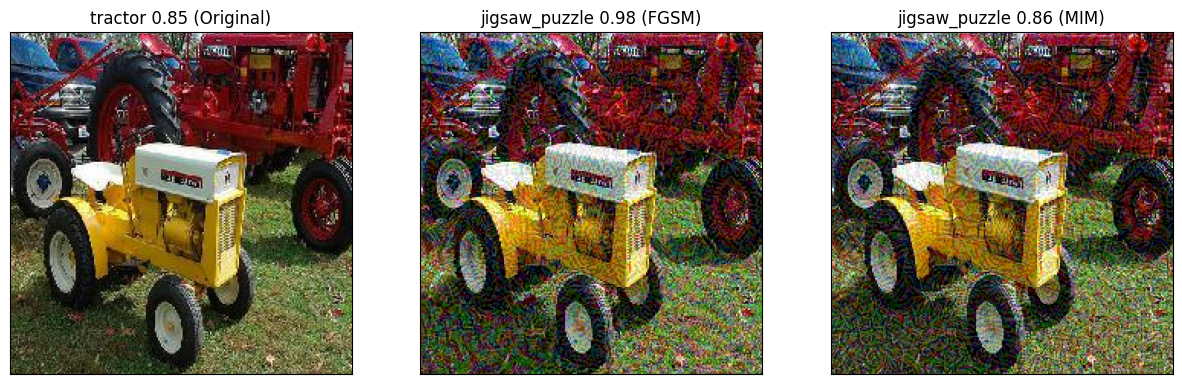

In [57]:
# Displaying predictions

txt_og = f"{pred1} {prob1:.2f} (Original)"
txt_fgsm = f"{pred2} {prob2:.2f} (FGSM)"
txt_mim = f"{pred3} {prob3:.2f} (MIM)"

img = load_image(img_path)
fgsm_img = fgsm_attack(img)
mim_img = mim_attack(img)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

ax = plt.subplot(1, 3, 1)
plt.imshow(img[0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title(txt_og)

ax = plt.subplot(1, 3, 2)
plt.imshow(fgsm_img)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title(txt_fgsm)

ax = plt.subplot(1, 3, 3)
plt.imshow(mim_img)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title(txt_mim)